In [1]:
# Numpy
import numpy as np

#Astro stuff
from astroquery.gaia import Gaia
import astropy.units as u
from astropy.table import Table

#Caching
from joblib import Memory

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

# MIST Models
import sys
sys.path.append(".")
from glob import glob
from read_mist_models import ISOCMD
import os

Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
def get_gaia_query_results(ra=66.75, dec=15.86, radius=2, conds="", limit=50000):
    add = ""
    if conds != "":
        add = f"AND {conds}"
    query = f"""
    SELECT TOP {limit} *
    FROM gaiaedr3.gaia_source
    WHERE 
        CONTAINS(
            POINT('ICRS',gaiaedr3.gaia_source.ra,gaiaedr3.gaia_source.dec),
            CIRCLE('ICRS',{ra},{dec},{radius})
        )=1
    """ + add
    print(query)
    job = Gaia.launch_job_async(query)
    return job.get_results()

In [31]:
def plot_hrd(data, title="", alpha=0.05, color=False, figsize=(8,8)):
    bp_rp = data['bp_rp'].data
    phot_g_mean_mag = data['phot_g_mean_mag'].data
    parallax = data['parallax'].data
    mg = phot_g_mean_mag+5*np.log10(parallax)-10
    fig, ax = plt.subplots(figsize=figsize)
    if color:
        h = ax.hist2d(bp_rp,mg,bins=300, norm=colors.PowerNorm(0.5), zorder=0.5)
        cb = plt.colorbar(h[3], ax=ax, pad=0.02)
    ax.scatter(bp_rp, mg, alpha=alpha, s=1, color='k', zorder=0)
    ax.invert_yaxis()
    plt.xlabel("BP-RP")
    plt.ylabel("Mg")
    plt.title(title)
    return ax

In [29]:
def plot_pm(data, title="", alpha=0.05, verbose=False, figsize=(8,8)):
    pmra = data['pmra'].data
    pmdec = data['pmdec'].data
    if verbose:
        print(f"RA mean: {np.mean(pmra)}, DEC mean:{np.mean(pmdec)}")
        print(f"RA max: {np.max(pmra)}, DEC max: {np.max(pmdec)}")
        print(f"RA min: {np.min(pmra)}, DEC min: {np.min(pmdec)}")
    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(pmra, pmdec, s=1, color='k')
    plt.title(title)
    plt.xlabel("Proper Motion: Right Ascension")
    plt.ylabel("Proper Motion: Declination")
    return ax

In [66]:
def load_isocmds(name):
    mist_fnames = glob(f"MIST/{name}*.iso.cmd")
    isocmds = {}
    for f in mist_fnames:
        key = f.rsplit(".", 2)[0]
        key = key.rsplit("_",1)[1]
        isocmds[float(key)/100] = ISOCMD(f)
    return isocmds

In [68]:
def load_dat(name):
    parsec_fnames = glob(f"PARSEC/{name}*.dat")
    tables = {}
    for f in parsec_fnames:
        key = f.rsplit(".", 2)[0]
        key = key.rsplit("_",1)[1]
        tables[float(key)/100] = Table.read(f, 
                                            format='ascii', 
                                            header_start=13)
        
    return tables

In [10]:
z = lambda fe: np.exp(0.977*fe-1.699)
fe = lambda z: 1.024*np.log(z)+1.739

In [9]:
def plot_temp_lum(isocmd = None, age_index=5.0):
    age_ind = isocmd.age_index(age_index)
#     logTeff = isocmd.isocmds[age_ind]['log_Teff']
    logTeff = isocmd.isocmds[age_ind]['Gaia_BP_DR2Rev'] - isocmd.isocmds[age_ind]['Gaia_RP_DR2Rev']
    logL = isocmd.isocmds[age_ind]['Gaia_G_DR2Rev']
    fe_h = isocmd.abun['[Fe/H]']
#     print(isocmd.isocmds[age_ind]['[Fe/H]'])
    plt.plot(logTeff, logL, label=f"Age Index: {age_index:.2f}, [Fe/H]: {fe_h:.2f}", alpha=0.4)
    plt.legend()

In [85]:
def plot_parsec(dat, age_index):
    unique_ages = np.unique(dat['logAge'])
    parsec = dat[dat['logAge'] == age_index]
    bp_rp = parsec['G_BPmag'] - parsec['G_RPmag']
    mg = parsec['Gmag']
    fe_h = fe(parsec['Zini'])[0]
    plt.plot(bp_rp, mg, label=f"Age Index: {age_index:.2f}, [Fe/H]: {fe_h:.2f}", alpha=0.4)
    plt.legend()

In [11]:
location = "./cachedir"
memory = Memory(location, verbose=0)
get_gaia_query_results_cached = memory.cache(get_gaia_query_results)

## Hyades Cluster

In [12]:
base_error_conds = '''
    parallax_over_error > 10
    AND phot_g_mean_flux_over_error>25
    AND phot_rp_mean_flux_over_error>10
    AND phot_bp_mean_flux_over_error>10
    AND pmra IS NOT NULL
    AND pmra_error < 0.1
    AND pmdec IS NOT NULL
    AND pmdec_error < 0.1
    AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND astrometric_excess_noise < 1
'''

The base query example given in _Babusiaux (2018)_ includes a lot of background-star filtering that already cleans up the majority of the HRD. Not including these base-level filters, returned a lot of unnecessary data that cluttered the HRD. Including additional filters on `astrometric_excess_noise` and `pmra`/`pmdec`/`parallax` allowed for a fairly good collection of data. 

In [13]:
hyades_pm_conds = '''
    ABS(parallax - 21.052) < 5
    AND ABS(pmra-4.614) < 300
    AND ABS(pmdec+7.705) < 400
'''

hyades_info = [66.75, 15.86, 5]
print("Starting stringent query...")
hyades_stringent = get_gaia_query_results_cached(ra = hyades_info[0],
                                                 dec = hyades_info[1],
                                                 radius = hyades_info[2],
                                                 conds = base_error_conds + "AND " + hyades_pm_conds)

Starting stringent query...

    SELECT TOP 50000 *
    FROM gaiaedr3.gaia_source
    WHERE 
        CONTAINS(
            POINT('ICRS',gaiaedr3.gaia_source.ra,gaiaedr3.gaia_source.dec),
            CIRCLE('ICRS',66.75,15.86,5)
        )=1
    AND 
    parallax_over_error > 10
    AND phot_g_mean_flux_over_error>25
    AND phot_rp_mean_flux_over_error>10
    AND phot_bp_mean_flux_over_error>10
    AND pmra IS NOT NULL
    AND pmra_error < 0.1
    AND pmdec IS NOT NULL
    AND pmdec_error < 0.1
    AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND astrometric_excess_noise < 1
AND 
    ABS(parallax - 21.052) < 5
    AND ABS(pmra-4.614) < 300
    AND ABS(pmdec+7.705) < 400

INFO: Query finished. [astroquery.utils.tap.core]


In [14]:
print("Starting condless query...")
hyades_condless = get_gaia_query_results_cached(ra = hyades_info[0],
                                                dec = hyades_info[1],
                                                radius = hyades_info[2],
                                                conds=base_error_conds)

Starting condless query...

    SELECT TOP 50000 *
    FROM gaiaedr3.gaia_source
    WHERE 
        CONTAINS(
            POINT('ICRS',gaiaedr3.gaia_source.ra,gaiaedr3.gaia_source.dec),
            CIRCLE('ICRS',66.75,15.86,5)
        )=1
    AND 
    parallax_over_error > 10
    AND phot_g_mean_flux_over_error>25
    AND phot_rp_mean_flux_over_error>10
    AND phot_bp_mean_flux_over_error>10
    AND pmra IS NOT NULL
    AND pmra_error < 0.1
    AND pmdec IS NOT NULL
    AND pmdec_error < 0.1
    AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND astrometric_excess_noise < 1

INFO: Query finished. [astroquery.utils.tap.core]


### [Hyades] HRD and Proper Motion Plots w/ proper motion and parallax cuts

In [15]:
hyades_stringent

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,deg,deg,deg,deg
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float64,float64,float64,float64
1636042515805110273,Gaia EDR3 45142206521351552,45142206521351552,36940397,2016.0,61.92552108068629,0.027922241,15.162685906660181,0.01612104,22.850537135218378,0.028883275,791.1339,129.84071,127.74418003865537,0.04115653,-23.238637670992127,0.024343599,-0.11751028,-0.14225836,-0.13101809,0.078020446,-0.17627358,-0.036509227,0.29818922,0.23841596,-0.096694626,-0.30046558,188,188,184,4,-3.4162867,718.20984,0.15080813,27.235142,31,True,1.6350477,--,--,--,--,--,--,--,21,13,0.05856452,29,8,11,0.08220789,85.21746,2,0,0.8232454,--,--,--,--,--,--,--,--,False,218,76028334.11389707,27638.504,2750.8123,5.984928,26,46659496.63540592,40804.332,1143.4937,6.166192,25,43189434.45228092,46177.7,935.2877,5.6594515,0,0,0,0,0,1.1817822,0.50674057,0.18126392,0.32547665,37.93208,0.46552494,9,6750.0,4.5,0.0,177.37820091592712,-26.33015320399188,62.840611894997984,-5.66878349571724
1636042515805110273,Gaia EDR3 45159901786885632,45159901786885632,945169460,2016.0,61.755680961496566,0.015764592,15.334941426173367,0.010946775,22.22862392233613,0.017393649,1277.9736,126.18647,124.62563850797356,0.019903427,-19.785723427617143,0.0144358

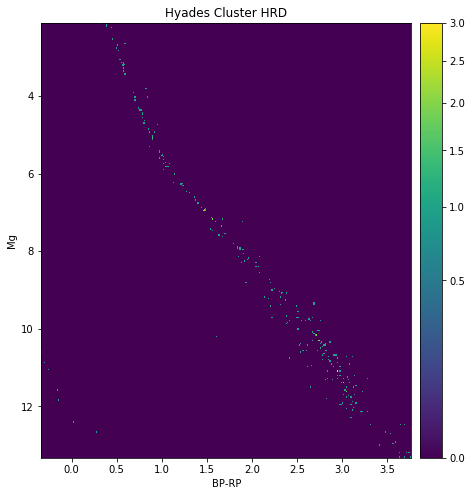

In [16]:
plot_hrd(hyades_stringent, title="Hyades Cluster HRD", alpha = 0.05, color = True)

RA mean: 86.74581812332562, DEC mean:-38.3022036078993
RA max: 268.45112859881044, DEC max: 157.6947104412314
RA min: -229.02440169940525, DEC min: -327.9489428466409


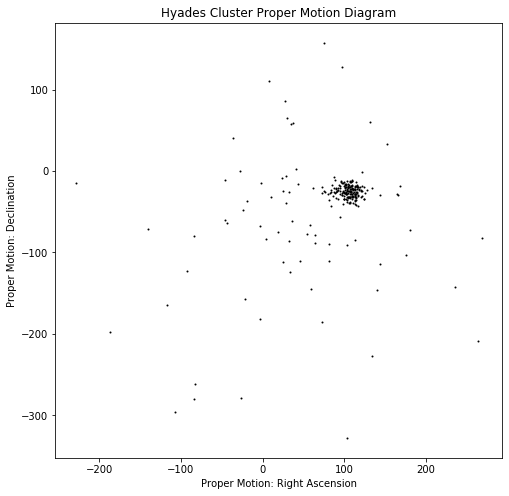

In [19]:
plot_pm(hyades_stringent, title="Hyades Cluster Proper Motion Diagram", alpha=1, verbose=True)

### [Hyades] HRD and Proper Motion Plots w/out proper motion and parallax cuts


In [20]:
hyades_condless

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,deg,deg,deg,deg
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float64,float64,float64,float64
1636042515805110273,Gaia EDR3 45903549604109184,45903549604109184,225872416,2016.0,62.28200531896495,0.037494704,16.618683701292667,0.027554745,0.806382297436968,0.04281058,18.83605,5.5238104,-2.6015379766632614,0.0557469,-4.872830887439466,0.042821407,0.19689064,0.1342041,0.021299718,0.009741926,-0.19762631,-0.016378166,0.26645094,0.156852,-0.022210894,0.21999034,278,0,275,3,1.4097203,314.46194,0.09023748,0.8564521,31,True,1.4213169,--,--,--,--,--,--,--,32,16,0.079487905,34,8,0,0.014144059,98.29156,1,0,1.060015,0.16060866,0.40707493,0.167498,0.42292354,-56.082623,-16.340183,-37.5405,34.949043,False,287,9007.327029998338,4.1523833,2169.1946,15.800877,33,3508.9774859102404,12.416609,282.60352,16.475592,33,8141.461930282397,11.239167,724.383,14.97114,0,2,0,0,0,1.2934402,1.5044518,0.67471504,0.8297367,--,--,0,--,--,--,176.42125209104879,-25.10776663475943,63.451765344990434,-4.302472362301102
1636042515805110273,Gaia EDR3 45903583963848320,45903583963848320,1616775635,2016.0,62.25789148177414,0.03346794,16.61942275783952,0.025504073,0.48253896425735626,0.038558803,12.514365,3.919604,2.594943759124962,0.047197632,

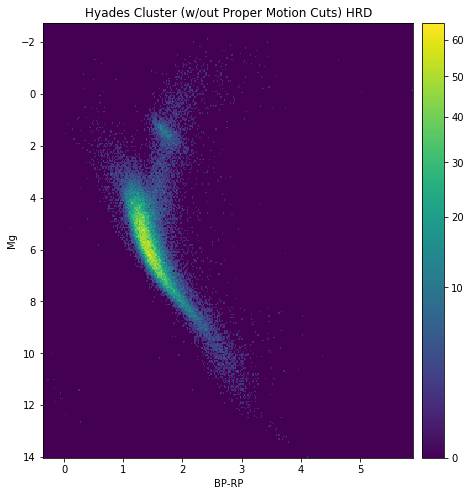

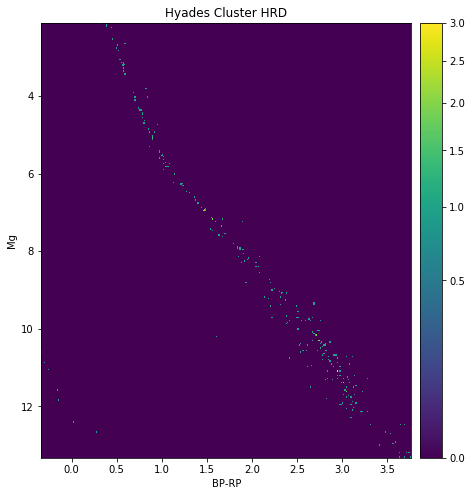

In [21]:
plot_hrd(hyades_condless, title="Hyades Cluster (w/out Proper Motion Cuts) HRD", alpha=0.05, color=True)
plot_hrd(hyades_stringent, title="Hyades Cluster HRD", alpha = 0.05, color = True)

The proper motion cuts cleaerly make the color-magnitude diagram a lot cleaner. The overall shape of the "with" and "without" proper motion filtering are about the same, but it is clear that the HRD that includes this filtering captures the more important stars.

RA mean: 4.447333444449148, DEC mean:-7.389081190734823
RA max: 656.6469583029074, DEC max: 157.6947104412314
RA min: -229.02440169940525, DEC min: -1116.5935413672632
RA mean: 86.74581812332562, DEC mean:-38.3022036078993
RA max: 268.45112859881044, DEC max: 157.6947104412314
RA min: -229.02440169940525, DEC min: -327.9489428466409


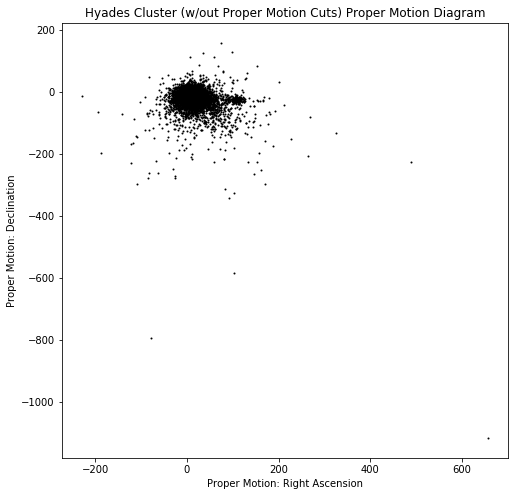

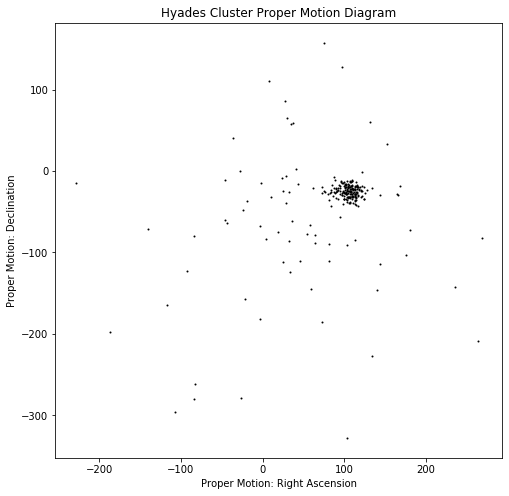

In [22]:
plot_pm(hyades_condless, title="Hyades Cluster (w/out Proper Motion Cuts) Proper Motion Diagram",alpha=1,verbose=True)
plot_pm(hyades_stringent, title="Hyades Cluster Proper Motion Diagram", alpha=1, verbose=True)

### Isochrones, MIST Models

In [26]:
hyades_isocmds = load_isocmds("Hyades")

Reading in: MIST/Hyades_02.iso.cmd
Reading in: MIST/Hyades_13.iso.cmd


In [27]:
isocmd = hyades_isocmds[0.02]
print('version: ', isocmd.version)
print('photometric system: ', isocmd.photo_sys)
print('abundances: ', isocmd.abun)
print('rotation: ', isocmd.rot)
print('ages: ', [round(x,2) for x in isocmd.ages])
print('number of ages: ', isocmd.num_ages)
print('available columns: ', isocmd.hdr_list)
print('Av extinction: ', isocmd.Av_extinction)

version:  {'MIST': '1.2', 'MESA': '7503'}
photometric system:  UBV(RI)c, 2MASS, Kepler, Hipparcos, Gaia (Vega)
abundances:  {'Yinit': 0.2713, 'Zinit': 0.0148362, '[Fe/H]': 0.02, '[a/Fe]': 0.0}
rotation:  0.4
ages:  [5.0, 5.05, 5.1, 5.15, 5.2, 5.25, 5.3, 5.35, 5.4, 5.45, 5.5, 5.55, 5.6, 5.65, 5.7, 5.75, 5.8, 5.85, 5.9, 5.95, 6.0, 6.05, 6.1, 6.15, 6.2, 6.25, 6.3, 6.35, 6.4, 6.45, 6.5, 6.55, 6.6, 6.65, 6.7, 6.75, 6.8, 6.85, 6.9, 6.95, 7.0, 7.05, 7.1, 7.15, 7.2, 7.25, 7.3, 7.35, 7.4, 7.45, 7.5, 7.55, 7.6, 7.65, 7.7, 7.75, 7.8, 7.85, 7.9, 7.95, 8.0, 8.05, 8.1, 8.15, 8.2, 8.25, 8.3, 8.35, 8.4, 8.45, 8.5, 8.55, 8.6, 8.65, 8.7, 8.75, 8.8, 8.85, 8.9, 8.95, 9.0, 9.05, 9.1, 9.15, 9.2, 9.25, 9.3, 9.35, 9.4, 9.45, 9.5, 9.55, 9.6, 9.65, 9.7, 9.75, 9.8, 9.85, 9.9, 9.95, 10.0, 10.05, 10.1, 10.15, 10.2, 10.25, 10.3]
number of ages:  107
available columns:  ['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bes

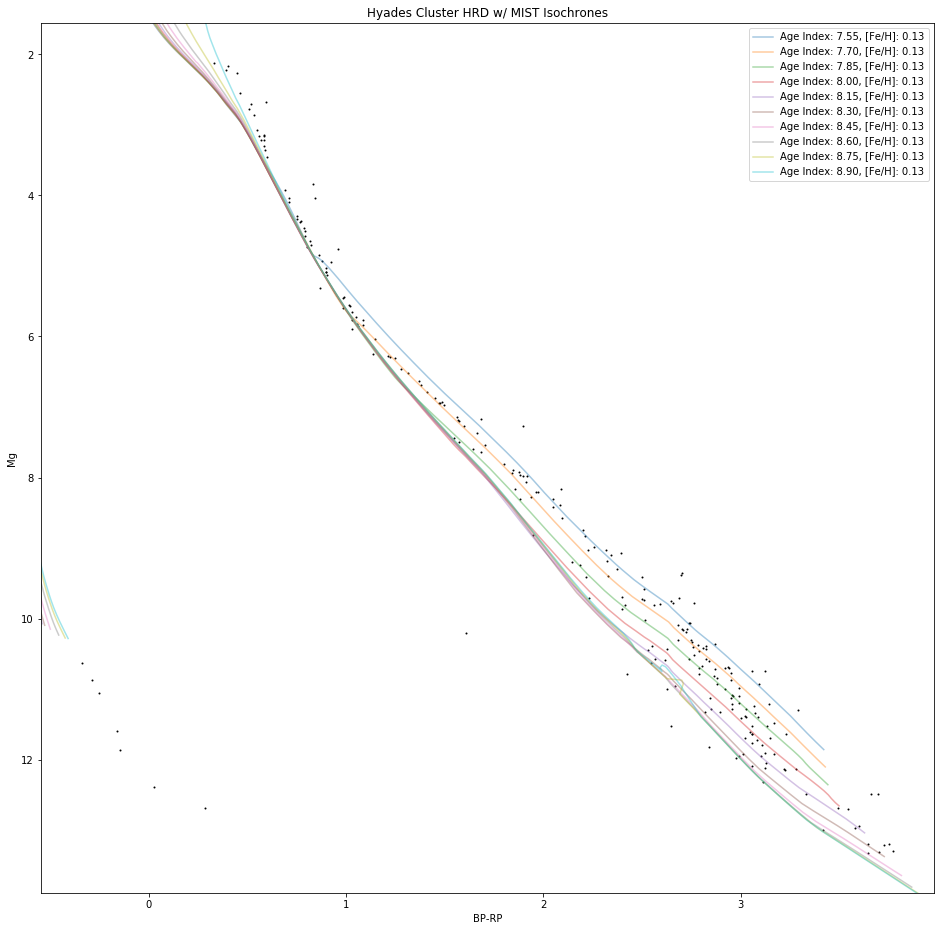

In [96]:
ax = plot_hrd(hyades_stringent,title="Hyades Cluster HRD w/ MIST Isochrones",alpha=1, color=False, figsize=(16,16))

ylim = plt.ylim()
xlim = plt.xlim()

#Isochrones
ages = np.array(hyades_isocmds[0.13].ages)
ages = ages[(ages < 9) & (ages > 7.5)]
for age in ages[::3]:
    plot_temp_lum(isocmd=hyades_isocmds[0.13], age_index = age)
plt.ylim(ylim)
plt.xlim(xlim)
plt.show()

For the Hyades cluster, we can see that most of the stars within the system lie on the main sequence. This implies that most of the stars are relatively young which was given in the prompt. On the bottom left, we see that there are a couple of white dwarves and overall there is a lack of giants. Given the cluster's strict adherence to the main sequence path with very little parallel sequences, the presence of binary or higher order stars is unlikely.

In [94]:
hyades_dats = load_dat("Hyades")
hyades_parsec = hyades_dats[.13]
print(hyades_parsec)

 Zini     MH   logAge     Mini     ... mbolmag  Gmag  G_BPmag G_RPmag
------ ------- ------ ------------ ... ------- ------ ------- -------
0.2076 0.69525    7.5 0.1000000015 ...  10.823 12.952  15.444  11.498
0.2076 0.69525    7.5 0.1136787981 ...  10.607 12.738  15.232  11.283
0.2076 0.69525    7.5 0.1199999973 ...  10.515 12.646  15.142  11.192
0.2076 0.69525    7.5 0.1400000006 ...  10.254 12.386  14.886  10.931
0.2076 0.69525    7.5 0.1431527734 ...  10.216 12.349  14.849  10.893
0.2076 0.69525    7.5 0.1599999964 ...  10.026 12.159  14.663  10.703
0.2076 0.69525    7.5 0.2030498981 ...   9.625 11.744   14.24   10.29
0.2076 0.69525    7.5 0.2409992516 ...   9.335 11.237  13.512    9.83
0.2076 0.69525    7.5 0.2550908625 ...   9.241 11.073   13.28   9.682
0.2076 0.69525    7.5 0.2814181447 ...   9.079 10.799  12.894   9.433
   ...     ...    ...          ... ...     ...    ...     ...     ...
0.2076 0.69525    8.9 2.4908051491 ...  -4.897  5.755  12.548   3.545
0.2076 0.69525    8.

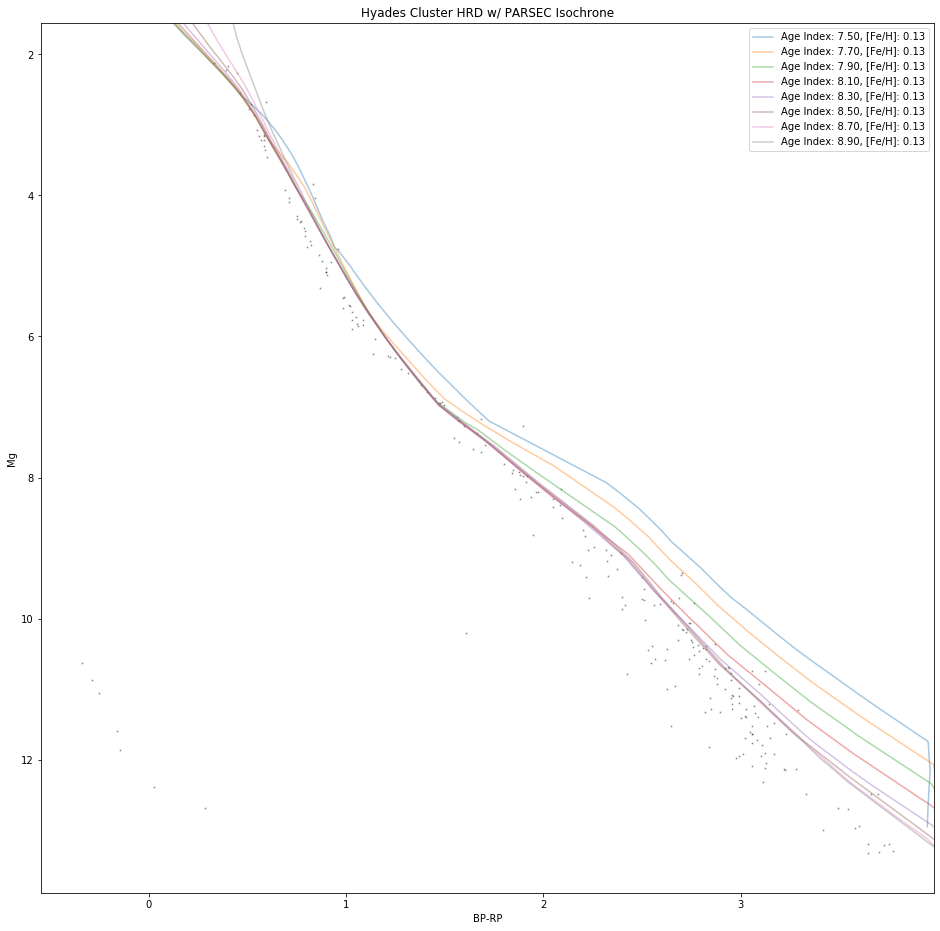

In [97]:
plot_hrd(hyades_stringent,title="Hyades Cluster HRD w/ PARSEC Isochrone",alpha=0.3, color=False, figsize=(16,16))

ylim = plt.ylim()
xlim = plt.xlim()

ages = np.unique(hyades_parsec['logAge'])
for age in ages:
    plot_parsec(dat=hyades_parsec, age_index = age)
plt.ylim(ylim)
plt.xlim(xlim)
plt.show()

## M67 Cluster

In [35]:
m67_pm_conds = '''
    ABS(parallax - 1.1325) < 1
    AND ABS(pmra+10.9737) < 2
    AND ABS(pmdec+2.9396) < 2
'''

m67_info = [132.6, 11.8167, 1]

In [36]:
print("Starting stringent query...")
m67_stringent = get_gaia_query_results_cached(ra = m67_info[0],
                                                 dec = m67_info[1],
                                                 radius = m67_info[2],
                                                 conds = base_error_conds + "AND " + m67_pm_conds)

Starting stringent query...

    SELECT TOP 50000 *
    FROM gaiaedr3.gaia_source
    WHERE 
        CONTAINS(
            POINT('ICRS',gaiaedr3.gaia_source.ra,gaiaedr3.gaia_source.dec),
            CIRCLE('ICRS',132.6,11.8167,1)
        )=1
    AND 
    parallax_over_error > 10
    AND phot_g_mean_flux_over_error>25
    AND phot_rp_mean_flux_over_error>10
    AND phot_bp_mean_flux_over_error>10
    AND pmra IS NOT NULL
    AND pmra_error < 0.1
    AND pmdec IS NOT NULL
    AND pmdec_error < 0.1
    AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND astrometric_excess_noise < 1
AND 
    ABS(parallax - 1.1325) < 1
    AND ABS(pmra+10.9737) < 2
    AND ABS(pmdec+2.9396) < 2

INFO: Query finished. [astroquery.utils.tap.core]


In [37]:
print("Starting relaxed query...")
m67_condless = get_gaia_query_results_cached(ra = m67_info[0],
                                                 dec = m67_info[1],
                                                 radius = m67_info[2],
                                                 conds = base_error_conds)

Starting relaxed query...

    SELECT TOP 50000 *
    FROM gaiaedr3.gaia_source
    WHERE 
        CONTAINS(
            POINT('ICRS',gaiaedr3.gaia_source.ra,gaiaedr3.gaia_source.dec),
            CIRCLE('ICRS',132.6,11.8167,1)
        )=1
    AND 
    parallax_over_error > 10
    AND phot_g_mean_flux_over_error>25
    AND phot_rp_mean_flux_over_error>10
    AND phot_bp_mean_flux_over_error>10
    AND pmra IS NOT NULL
    AND pmra_error < 0.1
    AND pmdec IS NOT NULL
    AND pmdec_error < 0.1
    AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND astrometric_excess_noise < 1

INFO: Query finished. [astroquery.utils.tap.core]


### [M67] HRD and Proper Motion Plots w/ proper motion and parallax cuts

In [38]:
m67_stringent

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,deg,deg,deg,deg
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float64,float64,float64,float64
1636042515805110273,Gaia EDR3 604680134842856704,604680134842856704,651239412,2016.0,133.2033879571266,0.028547933,11.198337484463524,0.016834244,1.0790031720689646,0.03626094,29.756624,11.333542,-10.97060208752885,0.03776496,-2.84518352048773,0.027516043,-0.46460417,-0.15743837,-0.13525932,-0.09428119,0.15802033,-0.020856833,-0.061180983,0.26832977,-0.14676777,-0.26221952,541,0,535,6,1.1336043,591.5682,0.07455098,1.170849,31,False,1.4944847,--,--,--,--,--,--,--,62,18,0.05465455,64,25,0,0.030526329,159.73955,1,0,1.0343835,0.078974895,0.62666404,0.26298386,0.1318994,122.4395,21.047667,46.098835,41.778923,False,542,11875.82411504634,3.0945482,3837.6602,15.500708,61,5614.298719800198,10.895721,515.2755,15.965303,57,8899.283223216853,13.063395,681.23816,14.874508,0,1,0,1,0,1.2221116,1.0907955,0.4645958,0.6261997,--,--,0,--,--,--,216.52309790183364,31.978890232297676,132.48361652280914,-6.099183838335868
1636042515805110273,Gaia EDR3 604682501369762048,604682501369762048,1810715821,2016.0,133.34051923140788,0.013560739,11.28739417204468,0.007829724,1.1498992967697386,0.017158924,67.01465,11.4398155,-11.086915216998

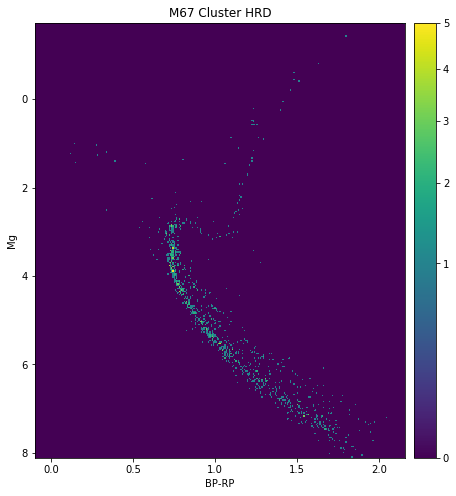

In [39]:
plot_hrd(m67_stringent, title="M67 Cluster HRD", alpha = 0.05, color = True)

RA mean: -10.933298831512467, DEC mean:-2.9091565324427053
RA max: -9.032715260797772, DEC max: -0.9599110280720821
RA min: -12.96915310620278, DEC min: -4.834680436626712


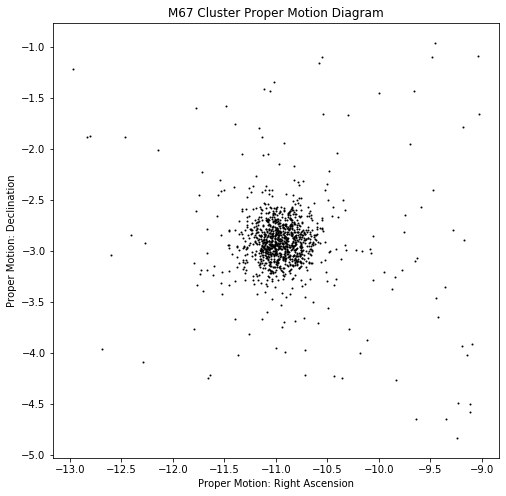

In [40]:
plot_pm(m67_stringent, title="M67 Cluster Proper Motion Diagram", alpha=1, verbose=True)

### [M67] HRD and Proper Motion Plots w/out proper motion and parallax cuts

In [41]:
m67_condless

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,deg,deg,deg,deg
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float64,float64,float64,float64
1636042515805110273,Gaia EDR3 604631584532535552,604631584532535552,1548541915,2016.0,133.31218240262024,0.016649809,11.120863227850771,0.0096830875,1.7557303958527313,0.021657733,81.06714,4.210459,-4.2039047790068755,0.022619348,0.23483944873210483,0.016681308,-0.43197072,-0.18338823,-0.20877214,-0.11748162,0.18216936,0.009866325,-0.07635684,0.40396026,-0.16914977,-0.32002413,636,7,634,2,-0.046978284,638.1953,0.0,3.2053086e-15,31,True,1.5070171,--,--,--,--,--,--,--,73,19,0.033631183,75,30,0,0.021811936,156.01717,0,0,0.9981461,--,--,--,--,--,--,--,--,False,648,31046.034745300505,11.514087,2696.3523,14.457352,72,15144.298646092217,23.218588,652.2489,14.887919,69,22595.181206315992,22.71501,994.7247,13.862856,0,5,0,4,0,1.2155974,1.0250635,0.43056774,0.5944958,--,--,0,--,--,--,216.6592829709904,32.04260810846042,132.608214659679,-6.144427412365482
1636042515805110273,Gaia EDR3 604631683316721024,604631683316721024,143969394,2016.0,133.24764551663907,0.01521527,11.115408543837793,0.009195657,0.8394808707317721,0.019292219,43.513966,6.2370725,0.5421749665203475,0.019237457,-6.213462540392228,0.0150197875,-0.4624347

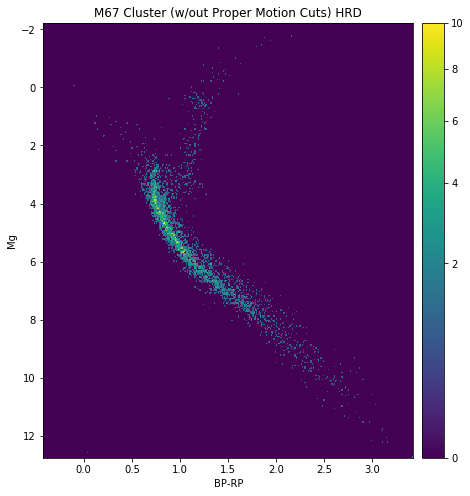

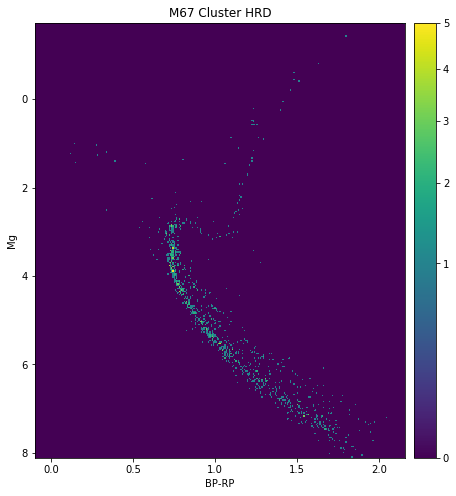

In [42]:
plot_hrd(m67_condless, title="M67 Cluster (w/out Proper Motion Cuts) HRD", alpha = 0.05, color = True)
plot_hrd(m67_stringent, title="M67 Cluster HRD", alpha = 0.05, color = True)

RA mean: -7.031031429907124, DEC mean:-6.0050105600786114
RA max: 163.0736863004018, DEC max: 49.36536595202559
RA min: -229.43830193224062, DEC min: -387.8486975238632
RA mean: -10.933298831512467, DEC mean:-2.9091565324427053
RA max: -9.032715260797772, DEC max: -0.9599110280720821
RA min: -12.96915310620278, DEC min: -4.834680436626712


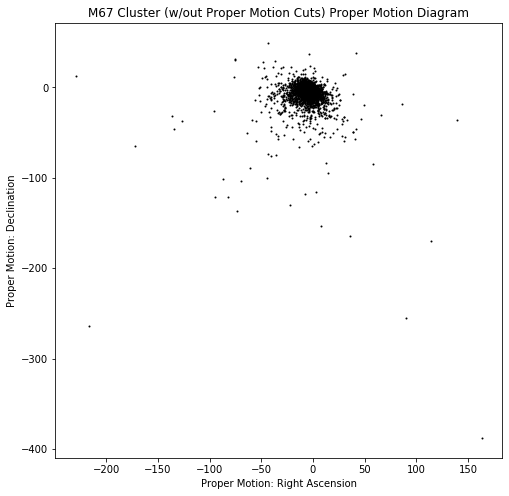

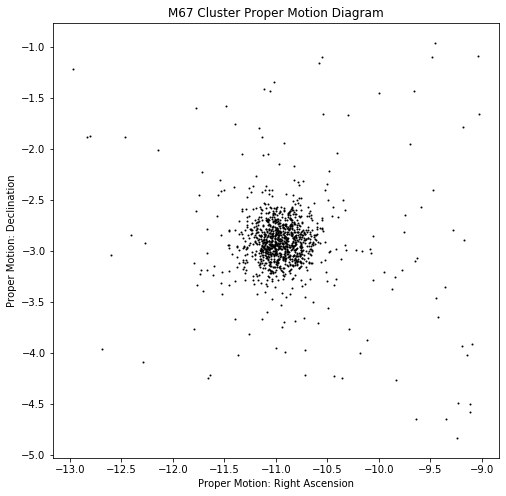

In [43]:
plot_pm(m67_condless, title="M67 Cluster (w/out Proper Motion Cuts) Proper Motion Diagram",alpha=1,verbose=True)
plot_pm(m67_stringent, title="M67 Cluster Proper Motion Diagram", alpha=1, verbose=True)

### [M67] Isochrones and MIST Models

In [44]:
m67_isocmds = load_isocmds("M67")

Reading in: MIST/M67_03.iso.cmd


In [45]:
isocmd = m67_isocmds[0.03]
print('version: ', isocmd.version)
print('photometric system: ', isocmd.photo_sys)
print('abundances: ', isocmd.abun)
print('rotation: ', isocmd.rot)
print('ages: ', [round(x,2) for x in isocmd.ages])
print('number of ages: ', isocmd.num_ages)
print('available columns: ', isocmd.hdr_list)
print('Av extinction: ', isocmd.Av_extinction)

version:  {'MIST': '1.2', 'MESA': '7503'}
photometric system:  UBV(RI)c, 2MASS, Kepler, Hipparcos, Gaia (Vega)
abundances:  {'Yinit': 0.2717, 'Zinit': 0.0151643, '[Fe/H]': 0.03, '[a/Fe]': 0.0}
rotation:  0.4
ages:  [5.0, 5.05, 5.1, 5.15, 5.2, 5.25, 5.3, 5.35, 5.4, 5.45, 5.5, 5.55, 5.6, 5.65, 5.7, 5.75, 5.8, 5.85, 5.9, 5.95, 6.0, 6.05, 6.1, 6.15, 6.2, 6.25, 6.3, 6.35, 6.4, 6.45, 6.5, 6.55, 6.6, 6.65, 6.7, 6.75, 6.8, 6.85, 6.9, 6.95, 7.0, 7.05, 7.1, 7.15, 7.2, 7.25, 7.3, 7.35, 7.4, 7.45, 7.5, 7.55, 7.6, 7.65, 7.7, 7.75, 7.8, 7.85, 7.9, 7.95, 8.0, 8.05, 8.1, 8.15, 8.2, 8.25, 8.3, 8.35, 8.4, 8.45, 8.5, 8.55, 8.6, 8.65, 8.7, 8.75, 8.8, 8.85, 8.9, 8.95, 9.0, 9.05, 9.1, 9.15, 9.2, 9.25, 9.3, 9.35, 9.4, 9.45, 9.5, 9.55, 9.6, 9.65, 9.7, 9.75, 9.8, 9.85, 9.9, 9.95, 10.0, 10.05, 10.1, 10.15, 10.2, 10.25, 10.3]
number of ages:  107
available columns:  ['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bes

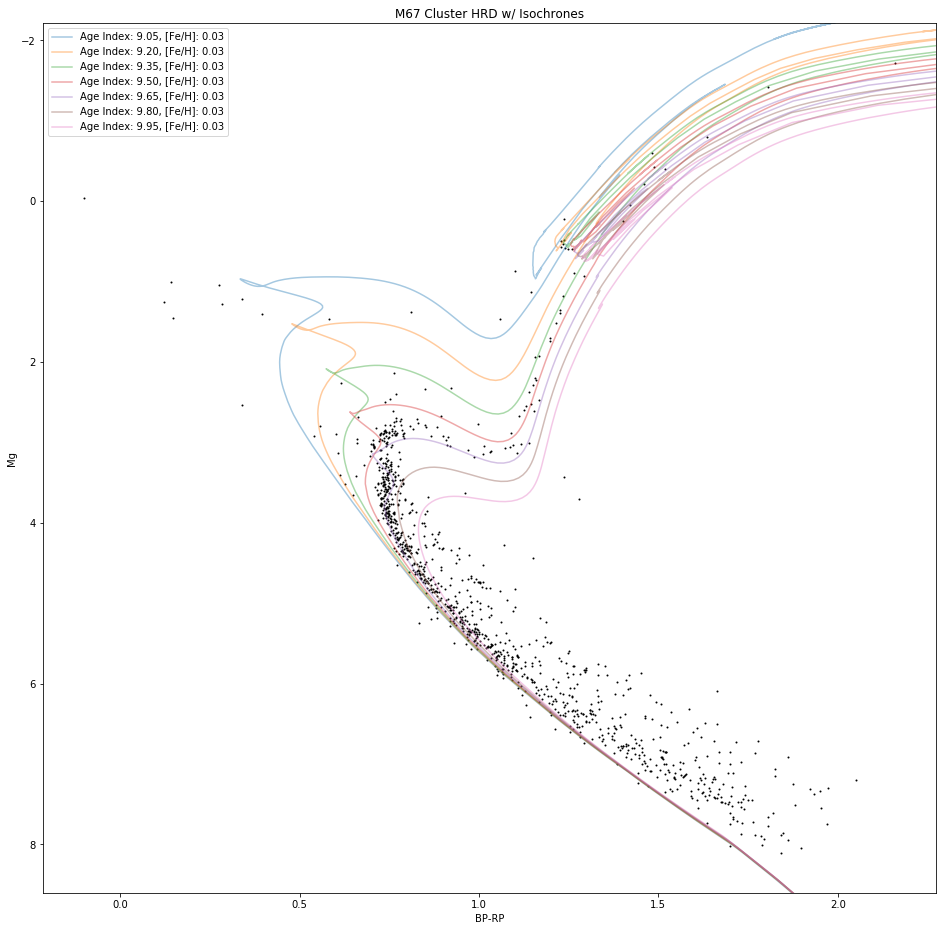

In [87]:
plot_hrd(m67_stringent,title="M67 Cluster HRD w/ Isochrones",alpha=1, color=False, figsize=(16,16))

ylim = plt.ylim()
xlim = plt.xlim()

ages = np.array(m67_isocmds[0.03].ages)
ages = ages[(ages < 10) & (ages > 9)]
for age in ages[::3]:
    plot_temp_lum(isocmd=m67_isocmds[0.03], age_index = age)
plt.ylim(ylim)
plt.xlim(xlim)
plt.show()

For the M67 cluster, we can see that much like the Hyades cluster, much of the stars within the system lie on the main sequence. Unlike the Hyades, the bottom left of the HRD is comepletely clear and we instead find many giants/supergiants in the top right. There seems to be a horizontal branch located in the top left of the system which marks many stars in the advanced stages of stellar evolution. Furthermore, in the bottom right we see what looks like a parallel branch which indicates the presence of binary and/or higher order star systems.

In [88]:
m67_dats = load_dat("M67")
m67_parsec = m67_dats[0.03]
print(m67_parsec)

 Zini     MH   logAge     Mini     ... mbolmag  Gmag  G_BPmag G_RPmag
------ ------- ------ ------------ ... ------- ------ ------- -------
0.1883 0.69525    9.0 0.1000000015 ...  12.903 15.146  17.932  13.653
0.1883 0.69525    9.0 0.1199999973 ...  12.396 14.637  17.411  13.146
0.1883 0.69525    9.0 0.1241446808 ...  12.316 14.557  17.329  13.065
0.1883 0.69525    9.0 0.1400000006 ...  12.006 14.245   17.01  12.755
0.1883 0.69525    9.0 0.1599999964 ...  11.683 13.922  16.678  12.432
0.1883 0.69525    9.0 0.1933609545 ...  11.246 13.356   15.95  11.895
0.1883 0.69525    9.0  0.200000003 ...  11.168 13.237  15.782  11.786
0.1883 0.69525    9.0 0.2085665017 ...  11.068  13.08  15.559  11.641
0.1883 0.69525    9.0 0.2586411834 ...  10.555 12.302  14.483  10.927
0.1883 0.69525    9.0 0.2623204589 ...  10.521 12.255  14.421  10.883
   ...     ...    ...          ... ...     ...    ...     ...     ...
0.1883 0.69525    9.8 1.2166919708 ...  -3.733  3.915   9.302   1.956
0.1883 0.69525    9.

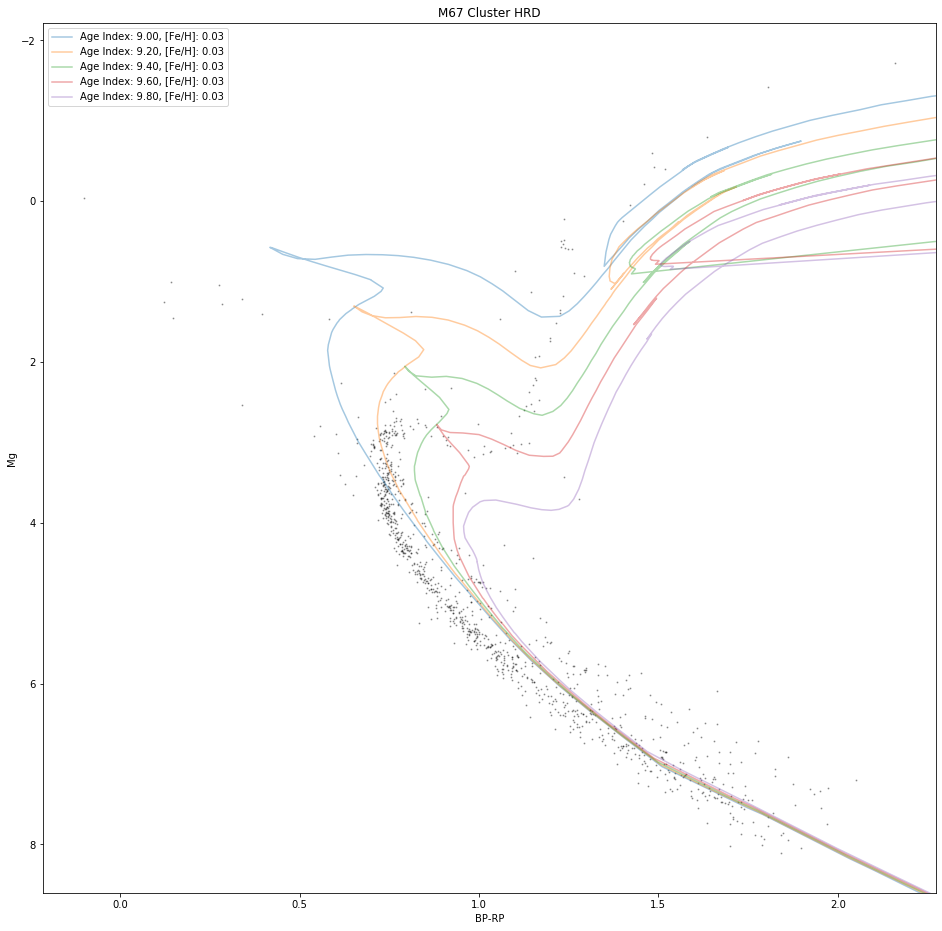

In [90]:
plot_hrd(m67_stringent,title="M67 Cluster HRD",alpha=0.3, color=False, figsize=(16,16))

ylim = plt.ylim()
xlim = plt.xlim()

ages = np.unique(m67_parsec['logAge'])
for age in ages:
    plot_parsec(dat=m67_parsec, age_index = age)
plt.ylim(ylim)
plt.xlim(xlim)
plt.show()

## NGC 6397 Cluster

In [47]:
relaxed_error_conds = '''
    parallax_over_error > 5
    AND phot_g_mean_flux_over_error>5
    AND phot_rp_mean_flux_over_error>5
    AND phot_bp_mean_flux_over_error>5
    AND pmra IS NOT NULL
    AND pmra_error < 0.1
    AND pmdec IS NOT NULL
    AND pmdec_error < 0.1
    AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND astrometric_excess_noise < 1
'''


ngc6397_pm_conds = '''
    ABS(parallax - 0.418) < 0.3
    AND ABS(pmra-3.56) < 1.5
    AND ABS(pmdec+17.34) < 1.5
'''

ngc6397_info = [265.175375, -53.6743333, 1]

Because NGC6397 is so far away, the `base_error_conds` from the _Babusiaux (2018)_ paper had to be relaxed.

In [48]:
print("Starting stringent query...")
ngc6397_stringent = get_gaia_query_results_cached(ra = ngc6397_info[0],
                                                 dec = ngc6397_info[1],
                                                 radius = ngc6397_info[2],
                                                 conds = relaxed_error_conds + "AND " + ngc6397_pm_conds)

Starting stringent query...

    SELECT TOP 50000 *
    FROM gaiaedr3.gaia_source
    WHERE 
        CONTAINS(
            POINT('ICRS',gaiaedr3.gaia_source.ra,gaiaedr3.gaia_source.dec),
            CIRCLE('ICRS',265.175375,-53.6743333,1)
        )=1
    AND 
    parallax_over_error > 5
    AND phot_g_mean_flux_over_error>5
    AND phot_rp_mean_flux_over_error>5
    AND phot_bp_mean_flux_over_error>5
    AND pmra IS NOT NULL
    AND pmra_error < 0.1
    AND pmdec IS NOT NULL
    AND pmdec_error < 0.1
    AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND astrometric_excess_noise < 1
AND 
    ABS(parallax - 0.418) < 0.3
    AND ABS(pmra-3.56) < 1.5
    AND ABS(pmdec+17.34) < 1.5

INFO: Query finished. [astroquery.utils.tap.core]


In [49]:
print("Starting relaxed query...")
ngc6397_condless = get_gaia_query_results_cached(ra = ngc6397_info[0],
                                                 dec = ngc6397_info[1],
                                                 radius = ngc6397_info[2],
                                                 conds = relaxed_error_conds)

Starting relaxed query...

    SELECT TOP 50000 *
    FROM gaiaedr3.gaia_source
    WHERE 
        CONTAINS(
            POINT('ICRS',gaiaedr3.gaia_source.ra,gaiaedr3.gaia_source.dec),
            CIRCLE('ICRS',265.175375,-53.6743333,1)
        )=1
    AND 
    parallax_over_error > 5
    AND phot_g_mean_flux_over_error>5
    AND phot_rp_mean_flux_over_error>5
    AND phot_bp_mean_flux_over_error>5
    AND pmra IS NOT NULL
    AND pmra_error < 0.1
    AND pmdec IS NOT NULL
    AND pmdec_error < 0.1
    AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND astrometric_excess_noise < 1

INFO: Query finished. [astroquery.utils.tap.core]


### [NGC 6397] HRD and Proper Motion Plots w/ proper motion and parallax cuts

In [50]:
ngc6397_stringent

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,deg,deg,deg,deg
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float64,float64,float64,float64
1636042515805110273,Gaia EDR3 5921315078495777792,5921315078495777792,673339048,2016.0,265.52916295545657,0.07886305,-54.14442590382663,0.06780843,0.4338318346298379,0.08602015,5.0433745,18.105438,3.7042797488485455,0.08793949,-17.7224497463011,0.07545,0.23332815,-0.12333772,-0.42828724,-0.27779204,-0.025787987,-0.22417767,-0.59270257,-0.083054855,0.07487197,-0.023055967,359,9,357,2,1.2970303,402.46033,0.22237337,1.1580633,31,False,1.5285046,--,--,--,--,--,--,--,41,20,0.13111041,41,20,0,0.023641048,17.604383,0,0,1.0483177,--,--,--,--,--,--,--,--,False,356,2060.9324540891275,1.7529507,1175.6934,17.402208,37,1059.6574512050618,6.66537,158.97954,17.775629,37,1412.4968190351667,8.037988,175.72766,16.872927,0,0,0,0,0,1.1995319,0.90270233,0.37342072,0.5292816,--,--,0,--,--,--,337.85322582201013,-12.373678629529362,266.9544114751897,-30.752400858095374
1636042515805110273,Gaia EDR3 5921315555227955072,5921315555227955072,279182444,2016.0,265.444161601995,0.056480523,-54.166252663303084,0.052371066,0.5092509624355199,0.062487498,8.149646,17.751396,3.580632016821064,0.062786356,-17.386520951042527,0.05651661,0.36289138

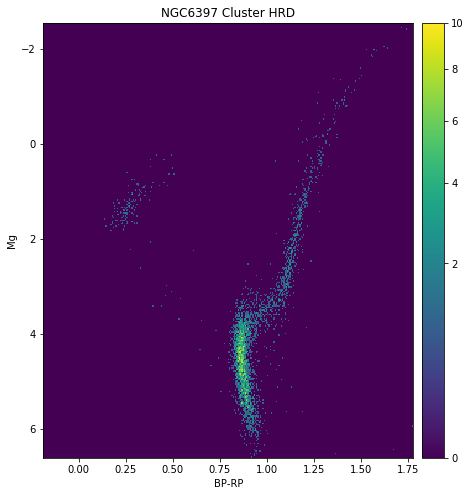

In [51]:
plot_hrd(ngc6397_stringent,title="NGC6397 Cluster HRD",alpha=0.05, color=True)

RA mean: 3.248615805866535, DEC mean:-17.640079695661036
RA max: 5.039486975777781, DEC max: -15.943484157452675
RA min: 2.073732573373989, DEC min: -18.763041984798402


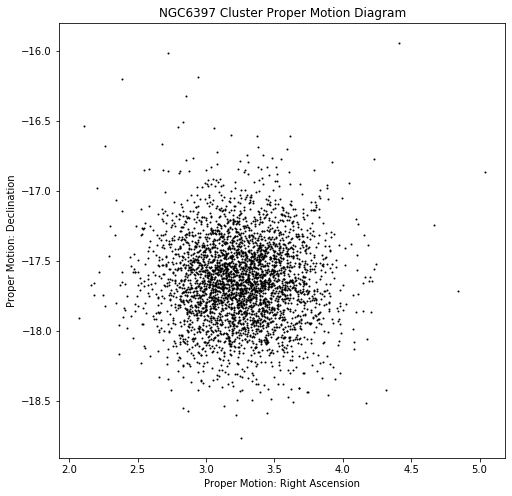

In [52]:
plot_pm(ngc6397_stringent,title="NGC6397 Cluster Proper Motion Diagram",alpha=0.05, verbose=True)

### [NGC 6397] HRD and Proper Motion Plots w/out proper motion and parallax cuts

In [53]:
ngc6397_condless

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,deg,deg,deg,deg
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float64,float64,float64,float64
1636042515805110273,Gaia EDR3 5921637578989585536,5921637578989585536,1643934738,2016.0,263.57992544016304,0.049062133,-53.462842105685304,0.04372285,0.5871378576604719,0.062727354,9.360156,10.05016,1.1632932233685005,0.057339825,-9.982608603407087,0.05031382,0.32661578,-0.2769544,-0.27320096,-0.3635345,-0.3464803,-0.101564445,-0.64270514,-0.23108108,0.43355152,-0.21857682,389,0,387,2,1.6551921,447.9832,0.16218778,1.7348114,31,False,1.4759405,--,--,--,--,--,--,--,44,19,0.08680154,46,20,0,0.03088141,8.040545,0,0,1.0595868,0.50635105,0.24739017,0.20582484,0.38168678,-156.52956,3.4514112,-18.559626,-41.292923,True,404,4580.841181803469,2.271831,2016.3652,16.535004,43,2130.4810153175745,11.6224985,183.30663,17.017347,40,3715.2662941294875,11.595483,320.40634,15.822921,0,43,0,40,0,1.2761296,1.1944265,0.48234367,0.71208286,--,--,0,--,--,--,337.85976371076583,-11.035982262243476,265.5860075821827,-30.121886908021892
1636042515805110273,Gaia EDR3 5921637609051132800,5921637609051132800,1048445827,2016.0,263.56727931390213,0.034393717,-53.44831612687455,0.031067511,0.80427859875795,0.040474318,19.87133,6.5618167,0.1665

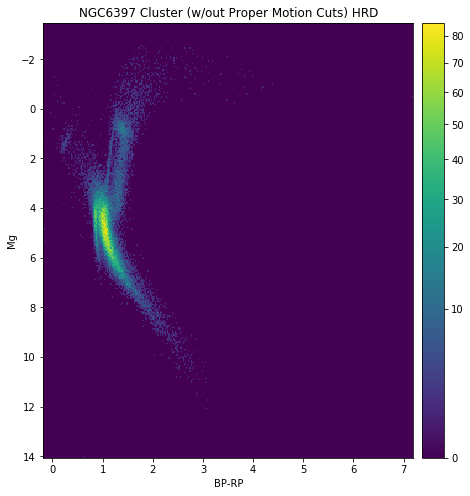

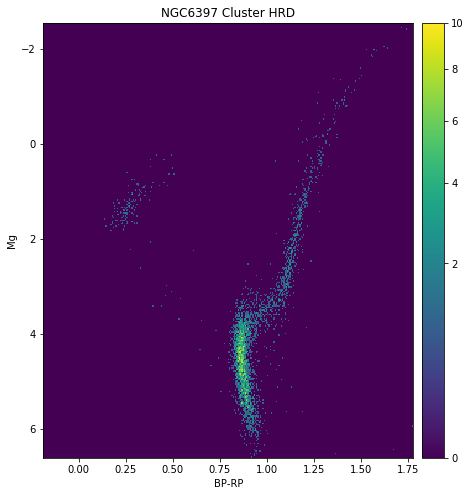

In [54]:
plot_hrd(ngc6397_condless,title="NGC6397 Cluster (w/out Proper Motion Cuts) HRD",alpha=0.05, color=True)
plot_hrd(ngc6397_stringent,title="NGC6397 Cluster HRD",alpha=0.05, color=True)

RA mean: -0.9247380029387059, DEC mean:-7.043219055693155
RA max: 168.19275495083087, DEC max: 45.97041002348057
RA min: -208.81970064016932, DEC min: -457.07725990704324
RA mean: 3.248615805866535, DEC mean:-17.640079695661036
RA max: 5.039486975777781, DEC max: -15.943484157452675
RA min: 2.073732573373989, DEC min: -18.763041984798402


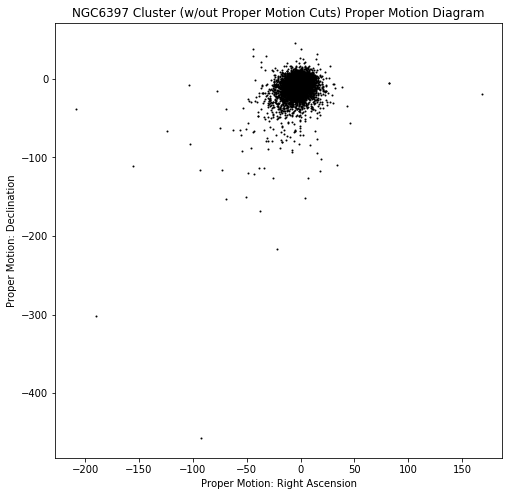

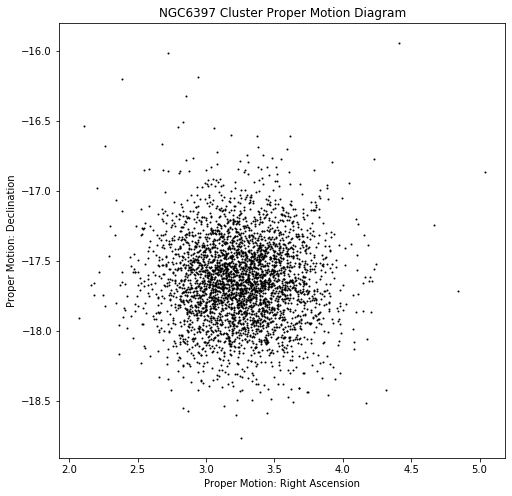

In [55]:
plot_pm(ngc6397_condless, title="NGC6397 Cluster (w/out Proper Motion Cuts) Proper Motion Diagram",alpha=1,verbose=True)
plot_pm(ngc6397_stringent, title="NGC6397 Cluster Proper Motion Diagram", alpha=1, verbose=True)

### [M67] Isochrones and MIST Models

In [56]:
ngc6397_isocmds = load_isocmds("NGC6397")

Reading in: MIST/NGC6397_-202.iso.cmd


In [57]:
isocmd = ngc6397_isocmds[-2.02]
print('version: ', isocmd.version)
print('photometric system: ', isocmd.photo_sys)
print('abundances: ', isocmd.abun)
print('rotation: ', isocmd.rot)
print('ages: ', [round(x,2) for x in isocmd.ages])
print('number of ages: ', isocmd.num_ages)
print('available columns: ', isocmd.hdr_list)
print('Av extinction: ', isocmd.Av_extinction)

version:  {'MIST': '1.2', 'MESA': '7503'}
photometric system:  UBV(RI)c, 2MASS, Kepler, Hipparcos, Gaia (Vega)
abundances:  {'Yinit': 0.2492, 'Zinit': 0.00014227, '[Fe/H]': -2.02, '[a/Fe]': 0.0}
rotation:  0.4
ages:  [5.0, 5.05, 5.1, 5.15, 5.2, 5.25, 5.3, 5.35, 5.4, 5.45, 5.5, 5.55, 5.6, 5.65, 5.7, 5.75, 5.8, 5.85, 5.9, 5.95, 6.0, 6.05, 6.1, 6.15, 6.2, 6.25, 6.3, 6.35, 6.4, 6.45, 6.5, 6.55, 6.6, 6.65, 6.7, 6.75, 6.8, 6.85, 6.9, 6.95, 7.0, 7.05, 7.1, 7.15, 7.2, 7.25, 7.3, 7.35, 7.4, 7.45, 7.5, 7.55, 7.6, 7.65, 7.7, 7.75, 7.8, 7.85, 7.9, 7.95, 8.0, 8.05, 8.1, 8.15, 8.2, 8.25, 8.3, 8.35, 8.4, 8.45, 8.5, 8.55, 8.6, 8.65, 8.7, 8.75, 8.8, 8.85, 8.9, 8.95, 9.0, 9.05, 9.1, 9.15, 9.2, 9.25, 9.3, 9.35, 9.4, 9.45, 9.5, 9.55, 9.6, 9.65, 9.7, 9.75, 9.8, 9.85, 9.9, 9.95, 10.0, 10.05, 10.1, 10.15, 10.2, 10.25, 10.3]
number of ages:  107
available columns:  ['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'B

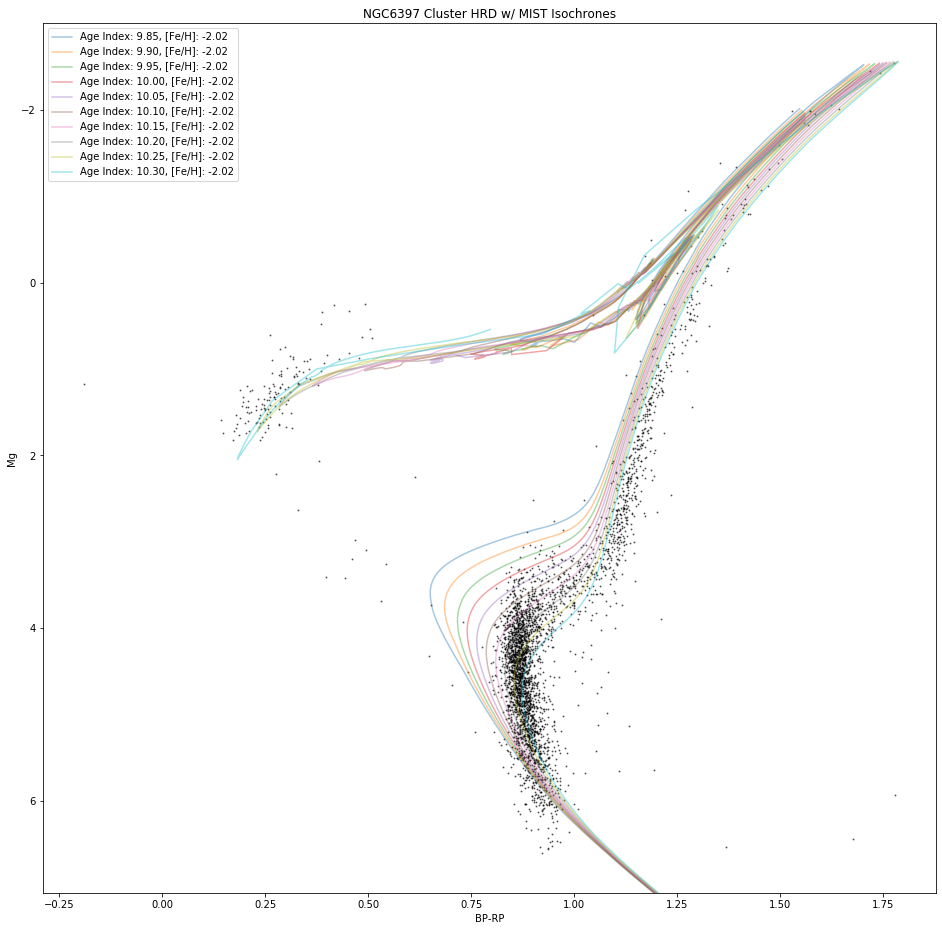

In [100]:
plot_hrd(ngc6397_stringent,title="NGC6397 Cluster HRD w/ MIST Isochrones",alpha=0.5, color=False, figsize=(16,16))

ylim = plt.ylim()
xlim = plt.xlim()

ages = np.array(ngc6397_isocmds[-2.02].ages)
ages = ages[(ages <= 10.5) & (ages > 9.8)]
for age in ages:
    plot_temp_lum(isocmd=ngc6397_isocmds[-2.02], age_index = age)
plt.ylim(ylim)
plt.xlim(xlim)
plt.show()

The NGC 6397 cluster is clearly relatively older than the other analyzed clusters. Firstly, while there are many stars still on the main sequence, similar to both the Hyades and M67 clusters, there is a strong presence of a Red Giant, Giant, and horizontal branches. The lack of parallel branches probably implies the absence of binary and/or higher order star systems.

In [73]:
ngc6397_dats = load_dat("NGC6397")
ngc6397_parsec = ngc6397_dats[-2.02]
print(ngc6397_parsec)

 Zini     MH   logAge     Mini     ... mbolmag  Gmag  G_BPmag G_RPmag
------ ------- ------ ------------ ... ------- ------ ------- -------
0.0254 0.25579   10.0  0.095894888 ...  13.129 15.235   18.03  13.753
0.0254 0.25579   10.0 0.1058055684 ...  12.782 14.887  17.674  13.407
0.0254 0.25579   10.0 0.1256269366 ...  12.227  14.33  17.102  12.851
0.0254 0.25579   10.0 0.1454483122 ...  11.804 13.789  16.405  12.337
0.0254 0.25579   10.0 0.1652696729 ...  11.469 13.263   15.65  11.856
0.0254 0.25579   10.0 0.2049123943 ...   10.93  12.47  14.555  11.127
0.0254 0.25579   10.0 0.2544658184 ...  10.416 11.778  13.655  10.484
0.0254 0.25579   10.0 0.3118847013 ...   9.935 11.153  12.859   9.903
0.0254 0.25579   10.0 0.3415722251 ...   9.716  10.88  12.523   9.648
0.0254 0.25579   10.0 0.3535726666 ...   9.632 10.777  12.399   9.551
   ...     ...    ...          ... ...     ...    ...     ...     ...
0.0254 0.25579   10.3 0.8869889975 ...  -2.697 -0.556   1.892  -1.945
0.0254 0.25579   10.

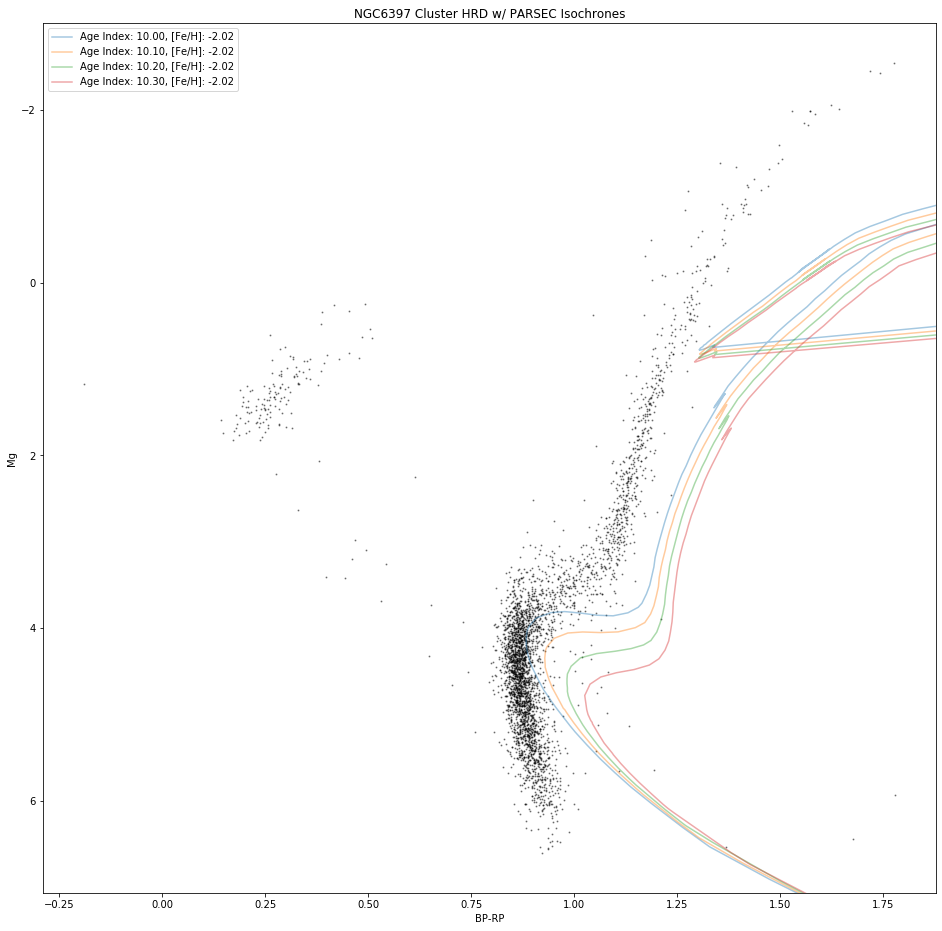

In [102]:
plot_hrd(ngc6397_stringent,title="NGC6397 Cluster HRD w/ PARSEC Isochrones",alpha=0.4, color=False, figsize=(16,16))

ylim = plt.ylim()
xlim = plt.xlim()

ages = np.unique(ngc6397_parsec['logAge'])
for age in ages:
    plot_parsec(dat=ngc6397_parsec, age_index = age)
plt.ylim(ylim)
plt.xlim(xlim)
plt.show()

Compared to the MIST data, the PARSEC data is generally less accurate. This is apparent in all three comparisons (Hyades, M67, and NGC6397). Furthermore, the log effective temperature data for these isochrones seems to be reddened which is most noticeable in the comparison for the NGC6397 cluster.